In [1]:
import scipy.io
import numpy as np
import itertools
from scipy.fftpack import fft, fftfreq
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import math
from scipy import stats
import csv
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import sklearn.preprocessing as prep
import sklearn.linear_model as linear_model

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.max_open_warning"] = 100

In [2]:
## import dataset
mat = scipy.io.loadmat('SSVEPDataset.mat')
data = mat['subject'][0]
number_of_subjects = len(data)
number_of_conditions = len(data[0])
number_of_samplings = len(data[0][0])
print "Data includes", number_of_subjects, "subjects :"
print "(", number_of_conditions, "conditions per subject )"
print "(", number_of_samplings, "samplings per condition )"
#print data

Data includes 12 subjects :
( 5 conditions per subject )
( 15000 samplings per condition )


In [3]:
def get_data(data, condition_id):

    #get data
    data_selected = np.zeros((number_of_subjects, number_of_samplings-number_of_filter_out_samplings))
    for i, d in enumerate(data):
        #one loop is one subject
        join_list = list(itertools.chain.from_iterable(d[condition_id-1]))

        #bandpass filter
        nyq = 0.5 * number_of_samplings_per_sec
        low = 7 / nyq
        high = 8 / nyq
        order = 2
        b, a = butter(order, [low, high], btype='band')
        f = lfilter(b, a, join_list)

        #filter out first-nine second
        data_selected[i] = f[number_of_filter_out_samplings:]

    print "Select data from condition #", condition_id
    print "Size of data is", len(data_selected), "subjects with", len(data_selected[0]), "samplings per subject."
    
    return data_selected

In [4]:
def perform_fft(data_selected, window_size):

    #FFT
    for i, d in enumerate(data_selected):
        #print "==== FFT with subjects #", i, "===="
        for index in range(0, number_of_slide_windows):
            #one loop per window
#             print "From second #", index, "to", index+window_size-1,"( sampling no.", \
#                     index*number_of_samplings_per_sec, "to", (index + window_size) * number_of_samplings_per_sec - 1, ")"

            #FFT
            fft_out = fft(d[index*number_of_samplings_per_sec : (index + window_size) * number_of_samplings_per_sec])

            freqs = fftfreq(len(fft_out)) * number_of_samplings_per_sec

            #Get maximum magnitude value from window_size freq
            if window_size == 4:
                fix_freq = 7.5
            elif window_size == 5:
                fix_freq = 7.6
            elif window_size == 6:
                fix_freq = 7.5
            elif window_size == 8:
                #still cannot find fix freq
                #peak is around 7.56-7.58
                #but after find from 7.5 to 7.8 (with scale + 0.00001), I still cannot find it
                fix_freq = 7.5
            elif window_size == 10:
                fix_freq = 7.6

            fft_out_max_list[i][index] = np.abs(fft_out)[np.where(freqs==fix_freq)]

            """
            if index == number_of_slide_windows - 1:
                #plot FFT of some specific window
                fig, ax = plt.subplots()
                ax.plot(freqs, np.abs(fft_out))
                ax.set_xlabel('Frequency in Hertz [Hz]')
                ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
                ax.set_xlim(1, 15)
                ax.set_ylim(1, 2500)
                plt.grid()
                plt.show() 
            """
            
        #z-score normalization
        fft_out_max_list[i] = stats.zscore(fft_out_max_list[i])  

        """
        plt.plot(fft_out_max_list[i], 'ro')
        plt.xlabel('Window no.')
        plt.ylabel('Max Spectrum Magnitude')
        plt.grid()
        plt.show()
        """
        
    return fft_out_max_list

In [5]:
def fit_curve(x, y, degree):
    return np.polyfit(x, y, degree)   

In [6]:
def plot_curve(coef, fft_out, y, cond, subj, window_size, curve_line=True):
    ys = []
    ffit = np.poly1d(coef)
    for i, x in enumerate(fft_out):
        ys.append(ffit(x))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    if curve_line:
        # rearrage to draw curve line
        tup = itertools.izip(fft_out, ys)
        result = sorted(tup, key=lambda t: t[0])
        xs = [x[0] for x in result]
        ys = [x[1] for x in result]
        ax1.plot( xs, ys, lw=3, color="#424949")
    else:
        xs = fft_out
        ax1.scatter( xs, ys, lw=3, color="#424949")
    
    ax1.scatter( fft_out, y, s=10, c='r', marker="o")
    ax1.set_xlim(-3.0, 3.0)
    ax1.set_ylim(65, 262)
    #plt.title('Window#' + str(window_size) + ', Subject#' + str(subj) + ', Condition#' + str(cond))
    #plt.legend(loc='upper right');
    #plt.show()
    print 'condition :', cond, 'subj:', subj, 'window:', window_size, coef
    plt.savefig('./results/con' + str(cond) + '_subj' + str(subj) + '_wind' + str(window_size) + '.pdf')
        
    return ys

In [7]:
def train_test_split(x, y, test_size = 1, fix_subject = None):
    
    r = [fix_subject]            
    print "Random result: subject #", r, "is test set."
    
    x_test = np.array([x[i] for i in r]).reshape(-1,1)
    x_train = np.array([x[i] for i in range(number_of_subjects) if i not in r]).reshape(-1,1)
    y_test = y[1:test_size+1]
    y_test = np.concatenate(y_test)
    y_train = y[1:number_of_subjects-test_size+1]
    y_train = np.concatenate(y_train)
    
    return x_train, \
            x_test, \
            y_train, \
            y_test, \
            r

In [8]:
def get_rmse(y_true, y_curve):
    return np.sqrt(np.sum(np.square(y_curve-y_true))/ len(y_true))

In [9]:
def get_r2(y_true, y_curve):
    return metrics.r2_score(y_true, y_curve)

In [10]:
def write_result_to_csv(results, res_type, degree):
    print 'Start writing results from', len(results), 'conditions'
    
    dir_path = './results/'
    filename = dir_path + res_type
    
    for index, r in enumerate(results):
        csvfile1 = open(filename + '_con' + str(conditions[index]) + \
                        '_win' + str(window_sizes) + '_degree' + str(degree) + '.csv', 'wb')

        wr1 = csv.writer(csvfile1, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)

        row = ['subject_id']
        for wind in window_sizes:
            row.append('win' + str(wind))
            
        wr1.writerow(row)

        for i in range(0, number_of_subjects):
            row = [i]
            for wind_index in range(0, number_of_window_sizes):
                row.append(results[index][wind_index][i])
            wr1.writerow(row)

        csvfile1.close()
    
    print 'Finish writing:', res_type

In [18]:
def plot_all_subject(xdata, ydata, cond, wind):
    print 'plotting curve of condition:', cond, 'window:', wind, 'with', len(xdata), 'subjects'
    
    X = np.array(xdata).reshape(len(xdata)*len(xdata[0]), 1)
    X = np.concatenate(X)
    y = np.array(ydata).reshape(len(ydata)*len(ydata[0]), 1)
    y = np.concatenate(y)

    coef = fit_curve(X, y, degree)
    
    ys = []
    ffit = np.poly1d(coef)
    for i, x in enumerate(X):
        ys.append(ffit(x))
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    # rearrage to draw curve line
    tup = itertools.izip(X, ys)
    result = sorted(tup, key=lambda t: t[0])
    xs = [x[0] for x in result]
    ys = [x[1] for x in result]
    ax1.plot( xs, ys, lw=3, color="#424949")
    
    ax1.scatter( X, y, s=10, c='r', marker="o")
    ax1.set_xlim(-3.0, 3.2)
    ax1.set_ylim(65, 262)
    #plt.title('Window#' + str(window_size) + ', Subject#' + str(subj) + ', Condition#' + str(cond))
    #plt.legend(loc='upper right');
    #plt.show()
    print 'condition :', cond, 'subj: all', 'window:', wind, coef
    plt.savefig('./results/con' + str(cond) + '_subj-all' + '_wind' + str(wind) + '.pdf')

################### window size = 5 ###################
Parameter settings: 1st window start at intensity = 75 , end at intensity = 216

Select data from condition # 3
Size of data is 12 subjects with 12750 samplings per subject.
plotting curve of condition: 3 window: 5 with 12 subjects
condition : 3 subj: all window: 5 [ -4.82345653   5.37614355  28.24466418 139.24657805]

Parameter settings: 1st window start at intensity = 255 , end at intensity = 117

Select data from condition # 4
Size of data is 12 subjects with 12750 samplings per subject.
plotting curve of condition: 4 window: 5 with 12 subjects
condition : 4 subj: all window: 5 [ -2.49319945  -2.07263566  30.43837578 188.6370193 ]



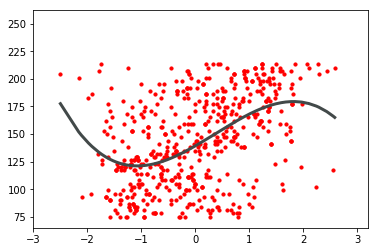

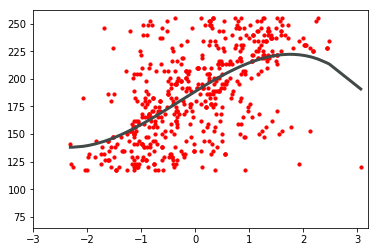

In [19]:
## get data, plot curve and get RMSE

#setting parameters
conditions = [3, 4]
number_of_samplings_per_sec = 250
filtered_secs = 9
degree = 3
window_sizes = [5] #seconds
selected_data_start = None #default is None
selected_data_end = None #default is None

number_of_selected_conditions = len(conditions)
number_of_window_sizes = len(window_sizes)
RMSE_all = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))
R2_all = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))
RMSE_avg = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))
R2_avg = np.zeros(shape = (number_of_selected_conditions, number_of_window_sizes, number_of_subjects))

for w, wind in enumerate(window_sizes):
    print '################### window size =', wind, '###################'
    all_secs = number_of_samplings/number_of_samplings_per_sec
    used_secs = all_secs - filtered_secs
    number_of_filter_out_samplings = number_of_samplings_per_sec * filtered_secs
    number_of_slide_windows = used_secs-wind+1
    fft_out_max_list = np.zeros((number_of_subjects, number_of_slide_windows))

    curve_coefs = []

    for i, cond in enumerate(conditions):
        
        # setting light intensity data
        intensity_step = 3
        if int(cond) == 5:
            first_light_intensity_begin = 150
            last_light_intensity_begin = 255
            light_intensity_up = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
            light_intensity_down = np.arange(last_light_intensity_begin, first_light_intensity_begin, -(intensity_step))
            light_intensity = np.concatenate([light_intensity_up, light_intensity_down])[0:number_of_slide_windows]
            last_light_intensity_begin = light_intensity[len(light_intensity)-1]
            light_intensity = np.tile(light_intensity,(number_of_subjects,1))
            selected_data_start = 25
            selected_data_end = 45
        elif cond == 4:
            first_light_intensity_begin = 255
            last_light_intensity_begin = 0
            light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, -(intensity_step))
            light_intensity = light_intensity[0:number_of_slide_windows]
            last_light_intensity_begin = light_intensity[len(light_intensity)-1]
            light_intensity = np.tile(light_intensity,(number_of_subjects,1))
            selected_data_start = 14
            selected_data_end = 34
        else:
            first_light_intensity_begin = 75
            last_light_intensity_begin = (number_of_slide_windows * intensity_step) + first_light_intensity_begin
            light_intensity = np.arange(first_light_intensity_begin, last_light_intensity_begin, intensity_step)
            light_intensity = np.tile(light_intensity,(number_of_subjects,1))
            selected_data_start = 14
            selected_data_end = 34

        print "Parameter settings: 1st window start at intensity =", first_light_intensity_begin, \
                ", end at intensity =", last_light_intensity_begin
        print
        
        data_selected = get_data(data, int(cond))
        fft_out_max_list = perform_fft(data_selected, wind)
        
        xs = []
        ys = []

        for subj in range(0, number_of_subjects):
            x = fft_out_max_list[subj]
            y = light_intensity[subj]
            if cond == 5.1:
                x = x[0:len(x)/2]
                y = y[0:len(y)/2]
            elif cond == 5.2:
                x = x[len(x)/2:len(x)]
                y = y[len(y)/2:len(y)]
            
            #coef = fit_curve(x, y, degree)
            #y_curve = plot_curve(coef, x, y, cond, subj, wind)
            
            xs.append(x)
            ys.append(y)
            
            #RMSE_all[i][w][subj] = get_rmse(y, y_curve)
            #R2_all[i][w][subj] = get_r2(y, y_curve)
            
        plot_all_subject(xs, ys, cond, wind)
        
        print '======================================='
        print

In [ ]:
print 'got results from', RMSE_all.shape[0], 'conditions, ', RMSE_all.shape[1], \
        'window sizes, ', RMSE_all.shape[2], 'subjects'
write_result_to_csv(RMSE_all, 'rmse', degree)
write_result_to_csv(R2_all, 'r2', degree)

In [ ]:
l1 = [[1, 2, 3], [11, 22, 33], [111, 222, 333], [1111, 2222, 3333]]
l1_re = np.array(l1).reshape(4*3, 1)
l1_re_con = np.concatenate(l1_re)
len(l1_re_con)